In [33]:
import torch
from PIL import Image
import os
from torchvision import transforms
Image.MAX_IMAGE_PIXELS = 150000000

tile_size = 512

parent_dir = "rois2/"
img_dir = parent_dir + "images/"
tile_dir = parent_dir + "tiles/"
model_dir = parent_dir + "models/"

output labels from tile_roi_with_labels:
    format - x-center, y-center, width, height (all normalized)

dataloader & create dataset - image, label, box

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
from utils import im_to_txt_path

def center_to_unorm_corner_coord(center_arr, img_size):
  xc, yc, w, h = center_arr
  xc, yc, w, h = xc * img_size, yc * img_size, w * img_size, h * img_size
  x1, y1, x2, y2 = xc - w/2, yc - h/2, xc + w/2, yc + h/2
  return [x1, y1, x2, y2]

input_imgs = []
input_targets = []
inputs = []

for root, dirs, files in os.walk(tile_dir + 'images/'):
    for file in files:
        if file.lower().endswith(('.png')):
            
            
            boxes = []
            labels = []
            
            if os.path.exists(im_to_txt_path(root + file)): 
                inputf = open(im_to_txt_path(root + file))
                for line in inputf.readlines():
                    temp = line.split(' ')
                    temp = [float(i) for i in temp]
                    labels.append(int(temp[0]))
                    x1, y1, x2, y2 = center_to_unorm_corner_coord(temp[1:], tile_size)
                    boxes.append([x1, y1, x2, y2])
                labels = torch.tensor(labels, dtype = torch.int64)
                boxes = torch.tensor(boxes, dtype = torch.float64)
            else:
                labels = torch.empty(0, dtype = torch.int64)
                boxes = torch.empty((0,4), dtype = torch.float64)
            
            
            input_imgs.append(root + file)
            # print(root+file)
            input_targets.append({'boxes': boxes, 'labels': labels})
            inputs.append({'image': root + file, 'target': {'boxes': boxes, 'labels': labels}})
                    
print(len(input_imgs))
print(len(input_targets))
print(len(inputs))
                    

36934
36934
36934


In [36]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import cv2
import re


define image augmentation

In [37]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import random

with open(tile_dir + 'mean_std.txt') as f:
    lines = f.readlines()
    
mean = []
std = []

for line in lines:
    if line.startswith("Mean: "):
        # Extract the numbers using regex
        numbers_str = re.findall(r'\[([0-9.\s]+)\]', line)[0]
        # Convert the string of numbers to a list of floats
        mean = np.fromstring(numbers_str, sep=' ').tolist()
    if line.startswith("Standard Deviation: "):
        # Extract the numbers using regex
        numbers_str = re.findall(r'\[([0-9.\s]+)\]', line)[0]
        # Convert the string of numbers to a list of floats
        std = np.fromstring(numbers_str, sep=' ').tolist()
print(mean)
print(std)

print(type(mean))

transform = A.Compose([
    A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    
    A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
    
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

random.seed(42)

def custom_collate_fn(batch):
    return list(batch)

class InputDataset(Dataset):

    def __init__(self, inputs_list):
       
        self.inputs_list = inputs_list

    def __len__(self):
        return len(self.inputs_list)

    def __getitem__(self, idx):
        
        img = cv2.imread(self.inputs_list[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_aug = transform(image = img, bboxes = self.inputs_list[idx]['target']['boxes'], class_labels = self.inputs_list[idx]['target']['labels'])['image']
        
        # img = img.permute(1,2,0)
        boxes = self.inputs_list[idx]['target']['boxes']
        labels = self.inputs_list[idx]['target']['labels']
        # clipped_boxes = torch.clamp(boxes, 0, 1)
        # transformed = transform(image = img, bboxes = clipped_boxes, labels = self.inputs_list[idx]['target']['labels'])
        
        # transformed_image = transformed['image']
        # transformed_bboxes = transformed['bboxes' ]
        # transformed_labels = transformed['labels']
        
        targets = {'boxes': (torch.tensor(boxes, dtype=torch.float64)), 'labels': torch.tensor(labels, dtype=torch.int64)}
        
        
        return {'image': img_aug, 'target': targets}


[0.63990641, 0.67864856, 0.74857624]
[0.23133176, 0.20776166, 0.17692773]
<class 'list'>


In [38]:
input_dataset = InputDataset(inputs)

train_dataset, val_dataset = torch.utils.data.random_split(input_dataset, [int(0.75*len(input_dataset)), len(input_dataset) - int(0.75*len(input_dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0,collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0,collate_fn=custom_collate_fn)

print(len(train_dataloader))
print(len(val_dataloader))


866
289


In [39]:
import pickle

os.makedirs(model_dir, exist_ok=True)
pickle.dump(train_dataloader, open(model_dir + "train_dataloader.pkl", "wb"))
pickle.dump(val_dataloader, open(model_dir + "val_dataloader.pkl", "wb"))

check if imgs and boxes are consistent

(512, 512, 3)
289 296 455 405


C:\Users\Tengyou Xu\AppData\Local\Temp\ipykernel_16604\3423164428.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = {'boxes': (torch.tensor(boxes, dtype=torch.float64)), 'labels': torch.tensor(labels, dtype=torch.int64)}


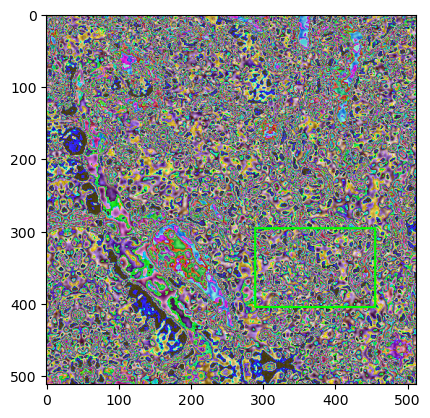

(512, 512, 3)
360 36 511 162


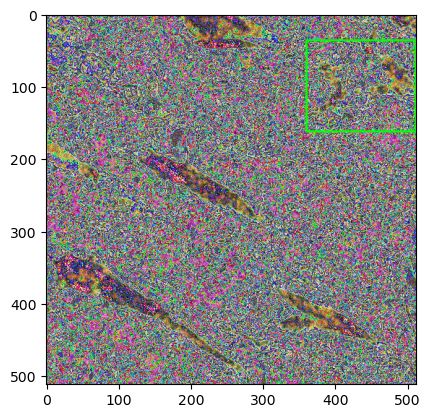

(512, 512, 3)
279 350 404 468


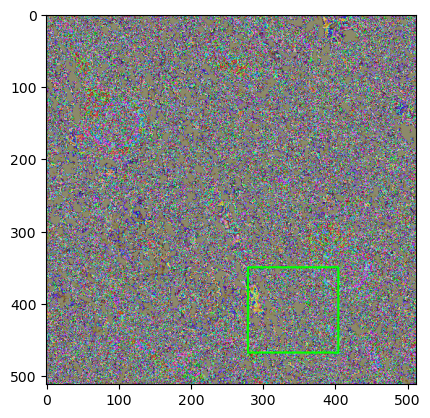

(512, 512, 3)
135 395 208 478


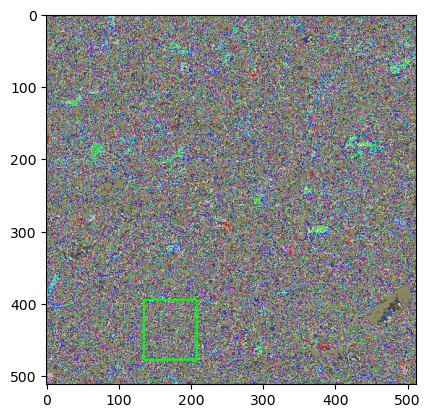

(512, 512, 3)
299 109 377 182


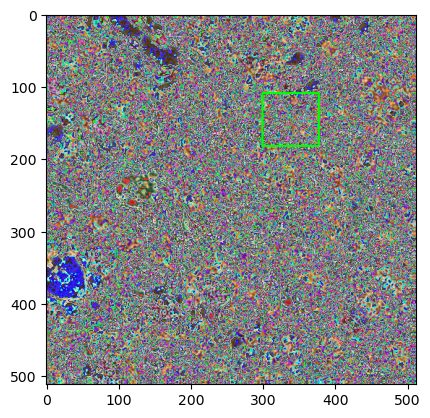

: 

In [43]:
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler

sampler = RandomSampler(train_dataset, num_samples=5, replacement=False)

rand_dataloader = DataLoader(train_dataset, batch_size=1, sampler=sampler)

for item in rand_dataloader:
    image = item['image'][0]
    
    img = image.clone().detach().numpy()
    
    print(img.shape)
    
    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = (img * 255).astype(np.uint8)
    # print(img.shape)
    target = item['target']
    for b in range(target['boxes'].shape[0]):
        box = target['boxes'][b].squeeze().tolist()
        # print(box,len(box))
        if len(box) == 0:
            continue
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        print(x1, y1, x2, y2)
        img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2) 
    # cv2.imshow('image', img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    

test iterating in train_dataloader

In [41]:
# for i, batch in enumerate(train_dataloader):
#     print (len(batch))
#     for item in batch:
#         print(item['image'].shape, item['target']['boxes'].shape, item['target']['labels'].shape)
#         if i >= 10:
#             break